In [1]:
import pandas as pd
import numpy as np
import time
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import osmnx as ox
from glob import glob
import us

In [2]:
us_map_url = "https://www2.census.gov/geo/tiger/TIGER2023/COUNTY/tl_2023_us_county.zip"

In [3]:
us_map = gpd.read_file(us_map_url)

In [4]:
nh_fips = us.states.lookup('NH').fips

In [5]:
new_hampshire = us_map[us_map['STATEFP']==nh_fips]

In [6]:
save_path = Path("../../spatial-data/osmnx_download/").resolve()
save_path.mkdir(parents=True, exist_ok=True)

In [7]:
# tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_counties_in_Illinois')
tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_counties_in_New_Hampshire')
county_list = tables[1]['County'].to_list()
county_list

['Belknap County',
 'Carroll County',
 'Cheshire County',
 'Coös County',
 'Grafton County',
 'Hillsborough County',
 'Merrimack County',
 'Rockingham County',
 'Strafford County',
 'Sullivan County']

In [8]:
start = time.perf_counter()
frames = []
pbar = tqdm(county_list, position=0, leave=True)
for county in pbar:
    pbar.set_description(f"Processing {county}")
    county_name = f"{county}, New Hampshire, United States"
    county_inf = ox.features_from_place(county_name, tags={"power":True})
    county_inf['COUNTY'] = county
    frames.append(county_inf)
    save_name = county.lower().replace(' county', '')
    save_to = save_path / f"nh_{save_name}_energy_inf.csv"
    county_inf.to_csv(str(save_to))
end = time.perf_counter()
print(f"Total download took {end-start:.3f} seconds")

Processing Sullivan County: 100%|██████████| 10/10 [01:20<00:00,  8.07s/it]   

Total download took 80.697 seconds


In [9]:
nh_inf = (pd.concat(frames, axis=0)
                .drop(columns=['COUNTY'])#, 'nodes','ways'])
                .reset_index()
                .drop_duplicates(subset=['osmid'])
                .set_index(['element_type','power','osmid'], drop=True)
                .replace(to_replace='NaN',value=np.nan)
                )

In [10]:
power_tags = ['generator','line','minor_line', 'plant','substation']

In [11]:
nh_inf = nh_inf.loc[nh_inf.index.get_level_values('power').isin(power_tags)].dropna(axis=1, how='all')

In [12]:
tech_columns = ['generator:type','plant:source','generator:source','plant:method','generator:method','geometry']

In [13]:
nh_inf.index.names

FrozenList(['element_type', 'power', 'osmid'])

fig, ax = plt.subplots()
illinois.plot(ax=ax, facecolor='None',edgecolor='k')

nh_inf[tech_columns].dropna(axis=0, how='all')\
    .iloc[nh_inf.index.get_level_values('power').isin(['generator','plant'])]\
        .to_crs(epsg=5070).centroid.to_crs(epsg=4269)\
        .plot(ax=ax, markersize=5)

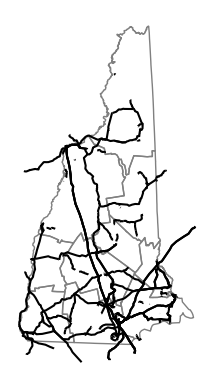

In [17]:
fig, ax = plt.subplots()
new_hampshire.plot(ax=ax, facecolor='None',edgecolor='gray')

nh_inf.iloc[nh_inf.index.get_level_values('power').isin([
                                                                    'line',
                                                                    #  'transmission',
                                                                    #  'minor_line',
                                                                    #  'cable'
                                                                     ])]\
                          .dropna(axis=1, how='all')\
                          .plot(ax=ax,edgecolor='k')
ax.set_axis_off()

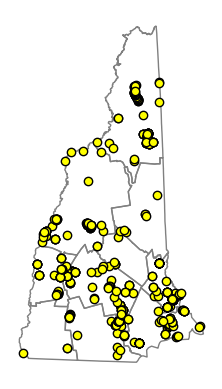

In [18]:
fig, ax = plt.subplots()
new_hampshire.plot(ax=ax, facecolor='None',edgecolor='gray')

nh_inf.iloc[nh_inf.index.get_level_values('power').isin(['generator', 'plant'
                                                                     ])]\
                          .dropna(axis=1, how='all')\
                              .to_crs(epsg=5070).centroid.to_crs(epsg=4269)\
                          .plot(ax=ax,facecolor='yellow',edgecolor='k')
ax.set_axis_off()
# ax.set_axis_off()
# ax

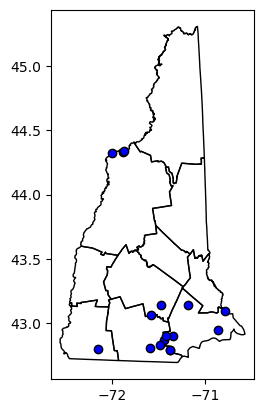

In [20]:
fig, ax = plt.subplots()
new_hampshire.plot(ax=ax, facecolor='None',edgecolor='k')
nh_inf[nh_inf.substation == 'transmission']\
                          .dropna(axis=1, how='all')\
                              .to_crs(epsg=5070).centroid.to_crs(epsg=4269)\
                          .plot(ax=ax,facecolor='blue', edgecolor='k')
plt.show()

In [18]:
nh_inf.loc[nh_inf.index.get_level_values("power").isin(['plant'])].dropna(axis=1, how='all')['plant:method'].unique()

array(['photovoltaic', 'combustion', nan, 'fission', 'run-of-the-river'],
      dtype=object)

In [50]:
new_hampshire

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
384,33,009,00873178,33009,0500000US33009,Grafton,Grafton County,06,H1,G4020,None,30150,None,A,4425249956,106463890,+43.9264391,-071.8424242,"POLYGON ((-71.86460 43.59806, -71.86523 43.597..."
753,33,019,00873183,33019,0500000US33019,Sullivan,Sullivan County,06,H1,G4020,None,30150,None,A,1393091317,36932078,+43.3611883,-072.2220839,"POLYGON ((-72.17119 43.57399, -72.17074 43.573..."
838,33,005,00873176,33005,0500000US33005,Cheshire,Cheshire County,06,H1,G4020,313,28300,None,A,1830367249,57589052,+42.9254596,-072.2481828,"POLYGON ((-72.06125 42.96581, -72.06131 42.964..."
920,33,007,00873177,33007,0500000US33007,Coos,Coos County,06,H1,G4020,None,None,None,A,4647923888,92542131,+44.6525477,-071.2894309,"POLYGON ((-71.24323 44.24375, -71.24393 44.243..."
1447,33,013,00873180,33013,0500000US33013,Merrimack,Merrimack County,06,H1,G4020,148,18180,None,A,2416197730,57178203,+43.2995786,-071.6800412,"POLYGON ((-71.47145 43.41130, -71.46959 43.410..."
1926,33,003,00873175,33003,0500000US33003,Carroll,Carroll County,06,H1,G4020,None,None,None,A,2413515422,159620276,+43.8677742,-071.2015596,"POLYGON ((-71.42651 44.21090, -71.42544 44.211..."
2019,33,015,00873181,33015,0500000US33015,Rockingham,Rockingham County,06,H1,G4020,148,14460,40484,A,1801055121,258626550,+42.9886636,-071.0990801,"POLYGON ((-70.99747 42.86444, -70.99950 42.864..."
2104,33,011,00873179,33011,0500000US33011,Hillsborough,Hillsborough County,06,H1,G4020,148,31700,None,A,2270202107,41309760,+42.9115317,-071.7230554,"POLYGON ((-72.03684 43.18247, -72.03311 43.183..."
3022,33,017,00873182,33017,0500000US33017,Strafford,Strafford County,06,H1,G4020,148,14460,40484,A,951743430,39154072,+43.2932725,-071.0355891,"POLYGON ((-70.83887 43.24449, -70.83886 43.244..."
3196,33,001,00873174,33001,0500000US33001,Belknap,Belknap County,06,H1,G4020,148,29060,None,A,1040780145,176540721,+43.5191091,-071.4253661,"POLYGON ((-71.43989 43.69556, -71.43818 43.694..."


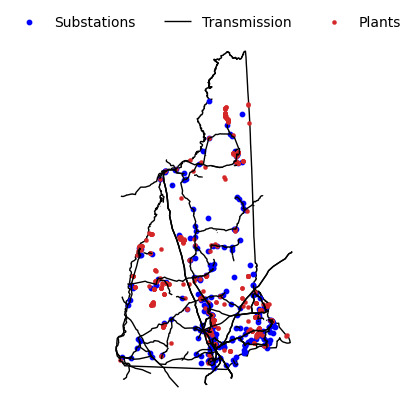

In [51]:
fig, ax = plt.subplots()
new_hampshire.dissolve("STATEFP").plot(ax=ax, facecolor='None',edgecolor='k')


# nh_inf[nh_inf.substation == 'transmission']\
#                           .dropna(axis=1, how='all')\
#                               .to_crs(epsg=5070).centroid.to_crs(epsg=4269)\
#                           .plot(ax=ax,facecolor='blue', markersize=4)
nh_inf.loc[nh_inf.index.get_level_values("power").isin(['substation'])]\
                          .dropna(axis=1, how='all')\
                              .to_crs(epsg=5070).centroid.to_crs(epsg=4269)\
                          .plot(ax=ax,facecolor='blue', markersize=10, label='Substations')
nh_inf.iloc[nh_inf.index.get_level_values('power').isin([
                                                                    'line',
                                                                    #  'transmission',
                                                                    #  'minor_line',
                                                                    #  'cable'
                                                                     ])]\
                          .dropna(axis=1, how='all')\
                          .plot(ax=ax,edgecolor='k', lw=1, label='Transmission')
nh_inf.loc[nh_inf.index.get_level_values("power").isin(['plant', 'generator'])]\
                          .dropna(axis=1, how='all')\
                              .to_crs(epsg=5070).centroid.to_crs(epsg=4269)\
                          .plot(ax=ax,facecolor='tab:red', markersize=10, edgecolor='tab:red', lw=0.1, label='Plants')
# ax.set_xlim(-89, -87.5)
# ax.set_ylim(41.2, 42.5)
ax.legend(loc=(-0.5, 1), ncols=3, facecolor='None', edgecolor='None')
ax.set_axis_off()

# Graph from lines using Momepy -- and a minimum spanning tree?

In [52]:
lines_df = nh_inf.xs((slice(None), 'line',slice(None))).dropna(axis=1, how='all')
# lines_df.head()

In [53]:
lines_df['voltage'].unique()

array(['115000', nan, '345000', '69000', '345000;115000', '22000',
       '450000', '230000', 'medium', '34500'], dtype=object)

In [54]:
line_cols = ['geometry','cables', 'frequency', 'voltage', 'line',]

In [55]:
lines_df=lines_df[line_cols]

In [56]:
lines_df.shape

(590, 5)

In [185]:
voltage_vals = ['138000', '161000', '345000', '138000;138000',
       '345000;138000', 
       # 'medium', '?', '69000', '69000;69000',
       '345000;345000', '34500', '230000', '138000;69000', '765000',
       '161000;69000', '345000;161000', '138000;',
       '345000;345000;138000', '138000;138000;138000', '1380000',
       '500000', '161000;161000', '345000;138000;138000', '230000;230000',
       '230000;138000', '138000;?']

In [57]:
voltage_vals = ['115000','345000', '69000', '345000;115000', '22000',
       '450000', '230000', '34500']

<Axes: >

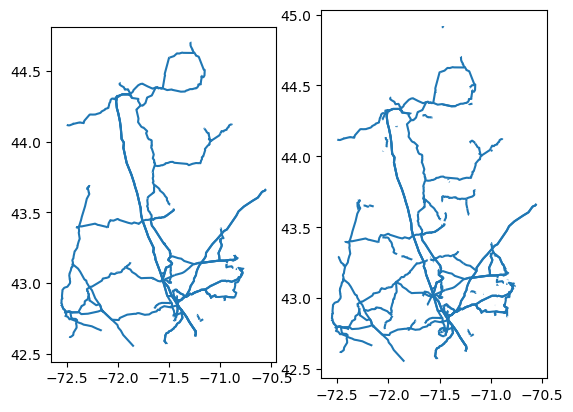

In [58]:
fig, ax = plt.subplots(1,2)
lines_df[lines_df['voltage'].isin(voltage_vals)].plot(ax=ax[0])
lines_df.plot(ax=ax[1])

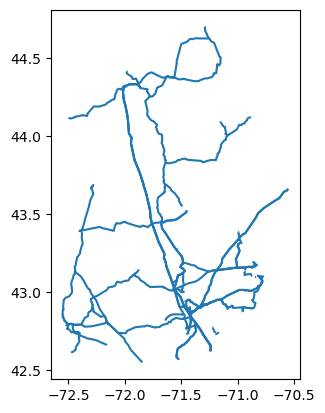

In [59]:
ax = lines_df[lines_df['voltage'].isin(voltage_vals)].plot()
# ax.set_xlim(-89, -87.5)
# ax.set_ylim(41.2, 42.5)

In [60]:
from libpysal import weights
import networkx as nx
import momepy

In [61]:
# lines_graph = momepy.gdf_to_nx(lines_df, approach="primal")
lines_graph = momepy.gdf_to_nx(lines_df[lines_df['voltage'].isin(voltage_vals)].to_crs(epsg=4269), approach="primal")

c:\Users\sdotson\AppData\Local\miniforge3\envs\ucs-model-review\lib\site-packages\momepy\utils.py:252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


In [62]:
positions = {n: [n[0], n[1]] for n in list(lines_graph.nodes)}

In [64]:
substations = nh_inf.xs((slice(None), 'substation', slice(None)))\
            .dropna(axis=1, how='all')
substations['centroid'] = substations.to_crs(epsg=5070).centroid.to_crs(epsg=4269)
# substation_cols = ['geometry', 'frequency', 'voltage',
#        'substation', 'name', 'vol', 'centroid']

# substations = substations[substation_cols]
substation_locs = substations.set_geometry(col='centroid', drop=True)

In [65]:
substation_locs.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

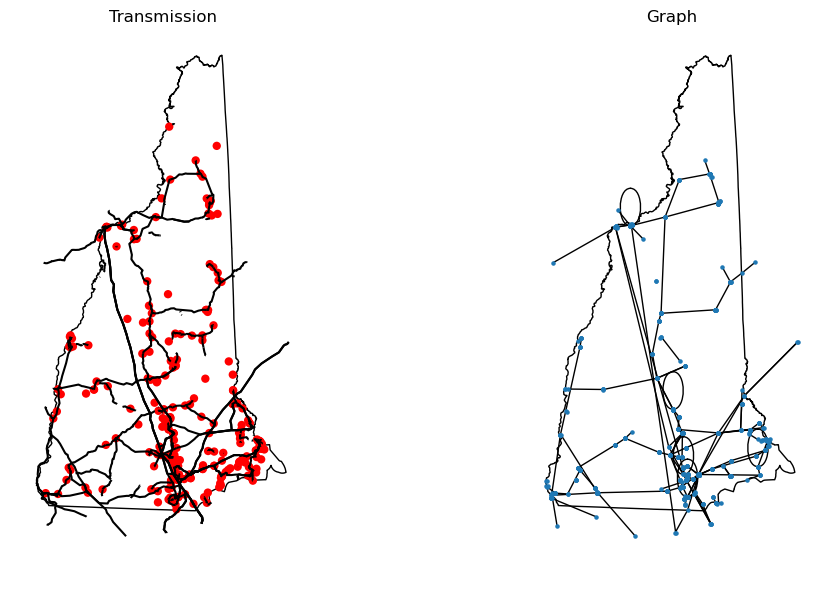

In [70]:
# Plot
f, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
new_hampshire.dissolve(by='STATEFP').plot(ax=ax[0], facecolor='None',edgecolor='k')
new_hampshire.dissolve(by='STATEFP').plot(ax=ax[1], facecolor='None',edgecolor='k')

lines_df.to_crs(epsg=4269).plot(color="k", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Transmission", "Graph")[i])
    facet.axis("off")
nx.draw(lines_graph, positions, ax=ax[1], node_size=5)
substation_locs.to_crs(epsg=4269).plot(ax=ax[0], edgecolor='None', facecolor='red')
# substation_locs.to_crs(epsg=4269).plot(ax=ax[1], edgecolor='r', facecolor='None')

# ax[0].set_xlim(-89, -87.5)
# ax[0].set_ylim(41.2, 42.5)

# ax[1].set_xlim(-89, -87.5)
# ax[1].set_ylim(41.2, 42.5)

# ax[0].set_axis_on()
# ax[0].tick_params(rotation=90)

# # The State of Illinois
# ax[0].set_xlim(3e5, 7.5e5)
# ax[0].set_ylim(1.5e6, 2.25e6)

# Northeastern Illinois
# ax[0].set_xlim(6e5, 7.05e5)
# ax[0].set_ylim(2.05e6, 2.2e6)
plt.tight_layout()